In [6]:
import requests
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import seaborn as sns
from sklearn.cluster import KMeans
from datetime import datetime, timedelta

Collect the dates from the previous x amount of days

In [13]:
def getDates(hist):
    dates = [] 

    for date in range(1, hist+1):
        dates.append(datetime.strftime(datetime.now() -timedelta(date), '%Y-%m-%d').split("-"))
    
    return dates

dates = getDates(5)

Extract data for the price in sek from the past x days

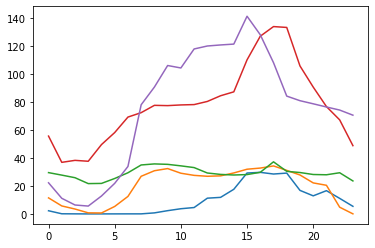

In [18]:
def getData(dates):

    mat = []

    for j in dates:
        response = requests.get(f"https://mgrey.se/espot?format=json&date={int(j[0])}-{int(j[1])}-{int(j[2])}")
        d = response.json()
        avgSum = []
        for k in d["SE1"]:
          avgSum.append(k["price_sek"])
        mat.append(avgSum)
        plt.plot(avgSum)
    
    return mat

mat = getData(dates)

Treat outliers using standard deviation

In [19]:
def trainData(mat):

    X = np.array(mat).T
    Xmean = []
    y=[]
    time = 1

    for i in X:
        i = list(i)
        for j in i:
            if j > np.mean(np.array(i))+(np.std(np.array(i))*3) or j < np.mean(np.array(i))-(np.std(np.array(i))*3):
                i.remove(j)
        i = np.array(i)
        Xmean.append(np.mean(i))
        y.append(time)
        time += 1
    
    return X, Xmean, y

X, Xmean, y = trainData(mat)

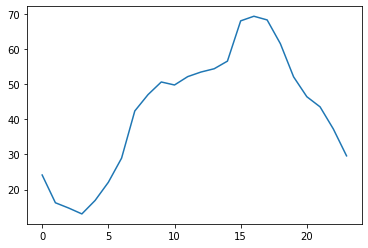

In [20]:
plt.plot(Xmean)

In [24]:
def findCenters(Xmean):
    Xmean = np.array(Xmean).reshape(-1,1)

    final = KMeans(n_clusters=3, random_state=0, max_iter = 300)
    final.fit(Xmean)

    centers = np.sort(np.array(final.cluster_centers_).flatten())

    return centers

centers = findCenters(centers)

Using centers, classify new prices into clusters:

- todayData - obtain the prices in the market at the current time
- classify - classify into the intervals using centers found in the k means

In [25]:
def todayData():
    date = datetime.strftime(datetime.now(), '%Y-%m-%d').split("-")
    response = requests.get(f"https://mgrey.se/espot?format=json&date={date[0]}-{date[1]}-{date[2]}")
    d = response.json()

    hours = [i["hour"] for i in d["SE1"]]
    price_eur = [i["price_eur"] for i in d["SE1"]]
    price_sek = [i["price_sek"] for i in d["SE1"]]
    kmeans = [i["kmeans"] for i in d["SE1"]]
    
    return hours, price_eur, price_sek, kmeans

In [26]:
def classify(centers, price_sek):
    intervals = centers

    m = []

    for i in price_sek:
        if i <= intervals[0]:
            m.append(0)
        elif i > intervals[0] and i <= intervals[1]:
            m.append(1)
        elif i > intervals[1] and i <= intervals[2]:
            m.append(2)
        else:
            m.append(3)
    
    return m

In [27]:
hours, price_eur, price_sek, kmeans = todayData()

preds = classify(centers, price_sek)

Visualize price and the classified predictions

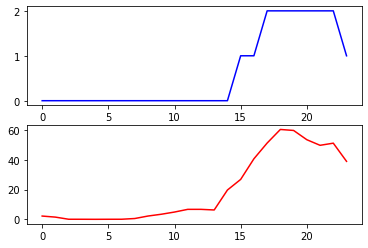

In [28]:
fig, axs = plt.subplots(2)
axs[0].plot(preds, color="blue", label="preds")
axs[1].plot(price_sek, color="red", label="truth")